# Examples of how asymmetric window improves the oracle performance
### Created by shanshan wang, Tampere university, Finalnd.

### import all the necessary packages

In [80]:
import soundfile as sf
import librosa
import numpy as np
from scipy import signal
from numpy.lib.stride_tricks import as_strided
from scipy.fftpack import fft, ifft
import sys
from mir_eval import separation
import matplotlib.pyplot as plt

### define the asymmetric analysis window and asymmetric synthesis window

In [81]:
def AsymSTFT(s,n_fft,winsize_long,winsize_short,hopsize):
    
    K = winsize_long
    M = winsize_short//2; # 64
    d = hopsize; #64
    #R = hopsize # frame advance
    
    pro_1 = K-M-d
    pro_2 = M
    win_pro_1 = signal.hann(2*pro_1,sym= False)
    win_pro_2 = signal.hann(2*pro_2,sym= False)
    
    win_an_1=np.zeros((d))
    win_an_2=np.sqrt(win_pro_1[:K-2*M-d])
    win_an_3=np.sqrt(win_pro_1[K-2*M-d:K-2*M-d+M])
    win_an_4=np.sqrt(win_pro_2[M:M+M])
    
    window_analysis = np.concatenate((win_an_1,win_an_2,win_an_3,win_an_4))
    
    sig_padded = np.pad(s,(winsize_long-winsize_short,0),'constant')
    n_frames=int((len(sig_padded)-K)/hopsize)+1
        
    y_frames = as_strided(sig_padded, shape=(K, n_frames),
                          strides=(sig_padded.itemsize, hopsize * sig_padded.itemsize))
    
    spectrogram_long = np.zeros((n_fft//2+1,n_frames),dtype=np.complex_)
    for i in np.arange(n_frames):
        
        
        a=y_frames[:,i]
        b=np.pad(a,(0,(n_fft-K)),'constant')
        
        window_analysis_ = np.pad(window_analysis,(0,n_fft-K),'constant')
        window_frame=b*window_analysis_
        spectra=fft(window_frame)
        spectra=spectra[:n_fft//2+1] 
        spectrogram_long[:,i]=spectra
    return spectrogram_long,np.abs(spectrogram_long),window_analysis
    
def AsymISTFT(spectrogram_long,s,winsize_long,winsize_short,hopsize):
     K = winsize_long
     M = winsize_short//2; # 64
     d = hopsize; #64
    
     pro_1 = K-M-d
     pro_2 = M
     win_pro_1 = signal.hann(2*pro_1,sym= False)
     win_pro_2 = signal.hann(2*pro_2,sym= False)
     
     win_sy_3=(win_pro_2[:M])/np.sqrt(win_pro_1[K-2*M-d:K-2*M-d+M])
     win_sy_4=np.sqrt(win_pro_2[M:M+M])
    
     window_synthesis = np.concatenate((win_sy_3,win_sy_4)) 
     n_frames=spectrogram_long.shape[1]
     output = np.zeros((s.shape[0]))
     for n_f in np.arange(n_frames):
        a=spectrogram_long[:,n_f]
        b=np.conjugate(spectrogram_long[:,n_f][-2:0:-1])
        c=np.concatenate((a,b))
       
        out_long = ifft(c).real
        out_long_wnd = out_long[K-winsize_short:K]
        #out_long_wnd = out_long[-window_synthesis.shape[0]:]
        out_long_wnd = window_synthesis*out_long_wnd
    
        output[n_f*hopsize:n_f*hopsize+2*M]=output[n_f*hopsize:n_f*hopsize+2*M]+ out_long_wnd

     return output, window_synthesis

### set the parameters to be used

In [82]:
n_fft =512
winsize_short = 128 # 8ms
winsize_long = 512 # 32ms
hopsize = 64 # 4ms

### load the example files

In [83]:
mix,sr = sf.read('mix.wav') 
s1,_ = sf.read('sig1.wav')                                                                                 
s2,_ = sf.read('sig2.wav') 

### calculate the spectrograms for the mixture signal and two sources using the asymmetric analysis window

In [84]:
spec0,spec_input_mix,window_analysis= AsymSTFT(mix,n_fft,winsize_long,winsize_short,hopsize)  
_,spec_input_s1,_= AsymSTFT(s1,n_fft,winsize_long,winsize_short,hopsize)       
_,spec_input_s2,_= AsymSTFT(s2,n_fft,winsize_long,winsize_short,hopsize) 

### get the oracle masks

In [85]:
epsi=sys.float_info.epsilon                                                                                                          
mask_1_es = spec_input_s1/(spec_input_s1+spec_input_s2+epsi)                                                
mask_2_es=1-mask_1_es

### reconstruct back the signals using the asymmetric synthesis window

In [86]:
s1e=spec0*mask_1_es                                                                                         
s2e=spec0*mask_2_es                                                                                         
                                                                                                                                      
es_s1_tr,window_synthesis=AsymISTFT(s1e,mix,winsize_long,winsize_short,hopsize)                      
es_s2_tr,_=AsymISTFT(s2e,mix,winsize_long,winsize_short,hopsize)                      
                                                                                                            
                                                                                                            
s1=s1[:np.min((len(es_s1_tr),len(s1)))]                                                                     
s2=s2[:np.min((len(es_s2_tr),len(s2)))]                                                                     
                                                                                                            

### calculate the SDR,SIR and SAR

In [87]:
groundtruth=np.zeros((2,len(s1)))                                                                           
estimate=np.zeros((2,len(s1)))                                                                              
groundtruth[0,:]=s1                                                                                         
groundtruth[1,:]=s2                                                                                         
estimate[0,:]=es_s1_tr                                                                                      
estimate[1,:]=es_s2_tr   
(sdr, sir, sar, perm)=separation.bss_eval_sources(groundtruth,estimate)
print('sdr', np.mean(sdr),'sir',np.mean(sir),'sar',np.mean(sar))

sdr 11.774106905078312 sir 16.69900677862306 sar 13.587681284113534


### visualize how asymmetric windows 

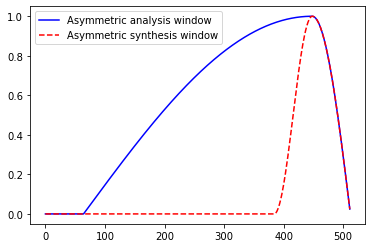

In [88]:
fig, ax = plt.subplots()
ax.plot(window_analysis,'-b', label='Asymmetric analysis window')
ax.plot(np.pad(window_synthesis,(winsize_long-winsize_short,0),'constant', constant_values=(0)),'--r', label='Asymmetric synthesis window')
leg = ax.legend();

### the oracle performace of using symmetric windows of 8 ms

In [89]:
spec0 = librosa.core.stft(mix,n_fft= 2* winsize_short,win_length=winsize_short,hop_length=hopsize)
spec_input_mix = np.abs(spec0)
spec_input_s1= np.abs(librosa.core.stft(s1,n_fft= 2* winsize_short,win_length=winsize_short,hop_length=hopsize))
spec_input_s2= np.abs(librosa.core.stft(s2,n_fft=2* winsize_short,win_length=winsize_short,hop_length=hopsize))
                                                                                                                
mask_1_es = spec_input_s1/(spec_input_s1+spec_input_s2+epsi)                                                
mask_2_es=1-mask_1_es                                                                                       
s1e=spec0*mask_1_es                                                                                         
s2e=spec0*mask_2_es                                                                                         
                                                                                                            
# =============================================================================                                                  
                                                                                                            
es_s1_tr=librosa.istft(s1e,win_length = 128 , hop_length=64)
es_s2_tr=librosa.istft(s2e,win_length = 128, hop_length=64)
s1=s1[:np.min((len(es_s1_tr),len(s1)))]                                                                     
s2=s2[:np.min((len(es_s2_tr),len(s2)))]                                                                     
                                                                                                            
groundtruth=np.zeros((2,len(s1)))                                                                           
estimate=np.zeros((2,len(s1)))                                                                              
groundtruth[0,:]=s1                                                                                         
groundtruth[1,:]=s2                                                                                         
estimate[0,:]=es_s1_tr                                                                                      
estimate[1,:]=es_s2_tr   
(sdr, sir, sar, perm)=separation.bss_eval_sources(groundtruth,estimate)
print('sdr', np.mean(sdr),'sir',np.mean(sir),'sar',np.mean(sar))

sdr 10.160924057085316 sir 15.108607660043127 sar 11.973578042377776


### the oracle performace of using symmetric windows of 32 ms

In [90]:
spec0 = librosa.core.stft(mix,n_fft= 2* winsize_long,win_length=winsize_long,hop_length=2*hopsize)
spec_input_mix = np.abs(spec0)
spec_input_s1= np.abs(librosa.core.stft(s1,n_fft= 2* winsize_long,win_length=winsize_long,hop_length=2*hopsize))
spec_input_s2= np.abs(librosa.core.stft(s2,n_fft= 2* winsize_long,win_length=winsize_long,hop_length=2*hopsize))
                                                                                                                
mask_1_es = spec_input_s1/(spec_input_s1+spec_input_s2+epsi)                                                
mask_2_es=1-mask_1_es                                                                                       
s1e=spec0*mask_1_es                                                                                         
s2e=spec0*mask_2_es                                                                                         
                                                                                                            
# =============================================================================                                                  
                                                                                                            
es_s1_tr=librosa.istft(s1e,win_length=winsize_long,hop_length=2*hopsize)
es_s2_tr=librosa.istft(s2e,win_length=winsize_long,hop_length=2*hopsize)
s1=s1[:np.min((len(es_s1_tr),len(s1)))]                                                                     
s2=s2[:np.min((len(es_s2_tr),len(s2)))]                                                                     
                                                                                                            
groundtruth=np.zeros((2,len(s1)))                                                                           
estimate=np.zeros((2,len(s1)))                                                                              
groundtruth[0,:]=s1                                                                                         
groundtruth[1,:]=s2                                                                                         
estimate[0,:]=es_s1_tr                                                                                      
estimate[1,:]=es_s2_tr   
(sdr, sir, sar, perm)=separation.bss_eval_sources(groundtruth,estimate)
print('sdr', np.mean(sdr),'sir',np.mean(sir),'sar',np.mean(sar))

sdr 13.123110917743563 sir 18.691159146897064 sar 14.616882030089938


# Results analysis

| window |(A,S) | SDR | SIR | SAR |
| --- | --- |--- | --- | --- |
| Sym|(8,8)| 10.16 | 15.11 | 11.97|
| **Asym** |(32,8)| **11.77** | **16.70** | **13.59**|
| Sym |(32,32) | 13.12 | 18.69 | 14.62|

#### We report an improvement of up to 1.5 dB in terms of SDR in our evaluation.
